In [1]:
import pandas as pd
import numpy as np

In [ ]:
# ---------------------------
# Load the datasets with error handling
# ---------------------------
try:
    df_cc = pd.read_csv('../data/processed/creditcard_processed.csv')
    print("Credit Card dataset loaded successfully!")
except FileNotFoundError:
    print("Error: creditcard_processed.csv file not found. Check the path.")
except pd.errors.EmptyDataError:
    print("Error: creditcard_processed.csv is empty.")
except Exception as e:
    print(f"An unexpected error occurred while loading credit card dataset: {e}")

try:
    df_fraud = pd.read_csv('../data/processed/fraud_data_processed.csv')
    print("Fraud dataset loaded successfully!")
except FileNotFoundError:
    print("Error: fraud_data_processed.csv file not found. Check the path.")
except pd.errors.EmptyDataError:
    print("Error: fraud_data_processed.csv is empty.")
except Exception as e:
    print(f"An unexpected error occurred while loading fraud dataset: {e}")

Data Preparation

In [ ]:
# ---------------------------
# Preprocessing and splitting (Fraud dataset)
# ---------------------------
try:
    # Target
    y_fraud = df_fraud['class']

    # Drop target and unnecessary columns
    x_fraud = df_fraud.drop(
        ["class", "user_id", "signup_time", "purchase_time", "device_id", "country"],
        axis=1,
        errors="ignore"
    )

    # Keep only numeric & boolean columns
    X_fraud = x_fraud.select_dtypes(include=["number", "bool"])

    # Fill any NaNs
    X_fraud = X_fraud.fillna(0)

    # Stratified train-test split
    X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = train_test_split(
        X_fraud, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud
    )

    print("Fraud dataset preprocessing and train-test split successful!")
except KeyError as ke:
    print(f"KeyError during preprocessing: {ke}")
except ValueError as ve:
    print(f"ValueError during train-test split: {ve}")
except Exception as e:
    print(f"An unexpected error occurred during preprocessing: {e}")



In [4]:
X_cc = df_cc.drop("Class", axis=1)
y_cc = df_cc["Class"]

X_train_cc, X_test_cc, y_train_cc, y_test_cc = train_test_split(
    X_cc,
    y_cc,
    test_size=0.2,
    stratify=y_cc,
    random_state=42
)

In [5]:
X_train_fraud

,purchase_value,age,ip_address,hour_of_day,day_of_week,time_since_signup,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_M,time_diff
50400,-1.415478,-0.596528,1.427384e+09,5.0,1.0,-0.354454,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3823915.0
95942,0.330990,-1.292769,2.742230e+09,16.0,5.0,1.336378,0.0,0.0,0.0,0.0,0.0,1.0,1.0,9109884.0
139235,-1.360900,-0.132367,3.967925e+09,12.0,0.0,0.078814,0.0,1.0,0.0,1.0,0.0,0.0,1.0,5178423.0
28234,2.404920,1.492195,7.883227e+08,21.0,1.0,0.332005,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5969962.0
123779,-0.487667,-1.524850,3.542046e+09,21.0,5.0,-0.188711,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4342070.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137952,2.404920,-0.132367,3.930389e+09,17.0,5.0,-0.178968,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4372530.0
13076,-0.160204,1.608235,3.608808e+08,22.0,0.0,1.655706,0.0,1.0,1.0,0.0,0.0,0.0,1.0,10108186.0
21982,0.822184,0.911994,6.042352e+08,5.0,5.0,1.280497,1.0,0.0,0.0,1.0,0.0,0.0,1.0,8935188.0
9161,1.149646,0.447833,2.502862e+08,21.0,0.0,-1.321222,0.0,0.0,0.0,1.0,0.0,0.0,1.0,801556.0


In [6]:
# separate features from target and perform SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_cc_res, y_train_cc_res = smote.fit_resample(X_train_cc, y_train_cc)
X_train_fraud_res, y_train_fraud_res = smote.fit_resample(X_train_fraud, y_train_fraud)


Build Baseline Model

In [7]:
# Train a Logistic Regression model as an interpretable baseline
from sklearn.linear_model import LogisticRegression
lr_cc = LogisticRegression(max_iter=1000, random_state=42)
lr_cc.fit(X_train_cc_res, y_train_cc_res)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [8]:
lr_fraud = LogisticRegression(max_iter=1000, random_state=42)
lr_fraud.fit(X_train_fraud_res, y_train_fraud_res)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [9]:
# Evaluate the model using AUC-PR, F1-Score and Confusion Matrix
from sklearn.metrics import (
    precision_recall_curve,
    auc,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

def evaluate_model(model, X_test, y_test):
    y_probs = model.predict_proba(X_test)[:, 1]
    y_test_pred = model.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    auc_pr = auc(recall, precision)
    f1 = f1_score(y_test, y_test_pred)
    cm = confusion_matrix(y_test, y_test_pred)

    print(f"AUC-PR: {auc_pr:.4f}")
    print(f"F1-Score: {f1:.4f}")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()


AUC-PR: 0.7150
F1-Score: 0.1002


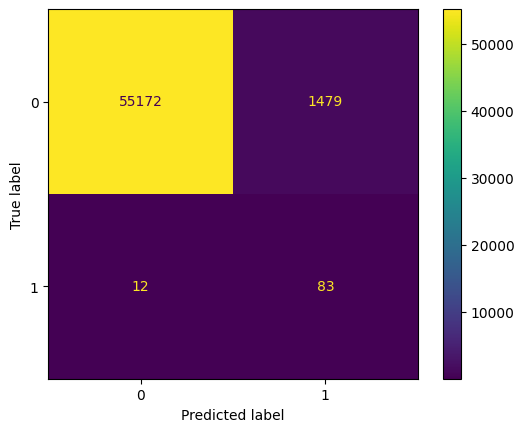

In [10]:
evaluate_model(lr_cc, X_test_cc, y_test_cc)

AUC-PR: 0.2808
F1-Score: 0.3072


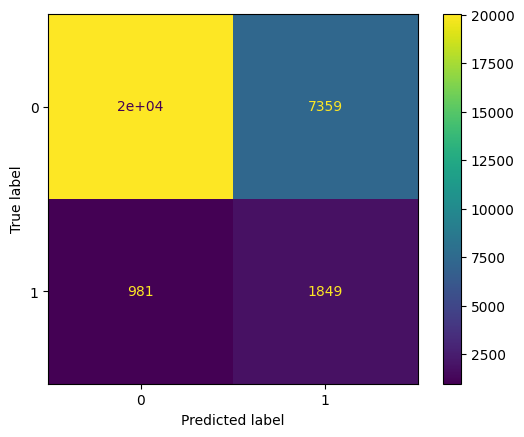

In [11]:
evaluate_model(lr_fraud, X_test_fraud, y_test_fraud)

Build Ensemble Model

In [12]:
# Train one of: Random Forest, XGBoost, or LightGBM
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_cc = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=15, n_jobs=-1)
rf_cc.fit(X_train_cc_res, y_train_cc_res)

,n_estimators,100
,criterion,'gini'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [13]:

rf_fraud = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=15, n_jobs=-1 )
rf_fraud.fit(X_train_fraud_res, y_train_fraud_res)

,n_estimators,100
,criterion,'gini'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


AUC-PR: 0.8039
F1-Score: 0.7590


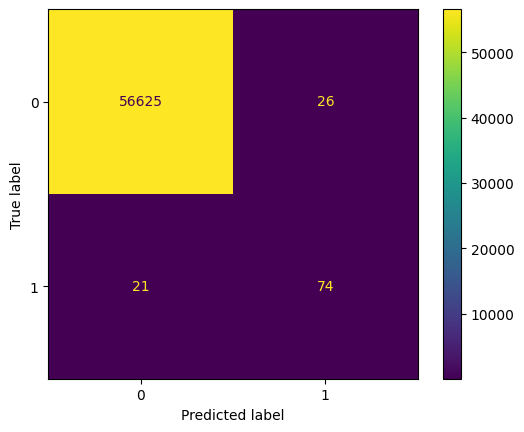

In [14]:
evaluate_model(rf_cc, X_test_cc, y_test_cc)

AUC-PR: 0.6215
F1-Score: 0.6875


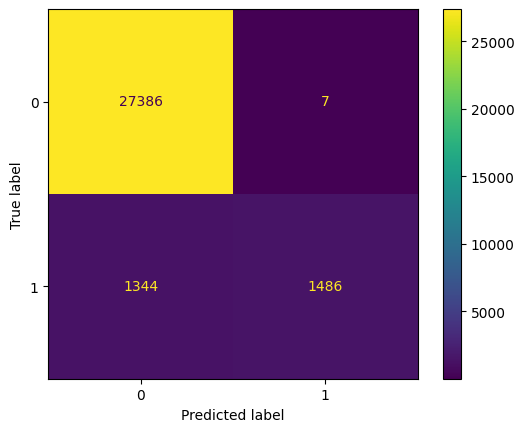

In [15]:
evaluate_model(rf_fraud, X_test_fraud, y_test_fraud)

In [ ]:
# Perform basic hyperparameter tuning (e.g., n_estimators, max_depth)
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20]
}
grid_search_cc = GridSearchCV(rf_cc, param_grid, scoring='f1', cv=3, n_jobs=-1)
grid_search_cc.fit(X_train_cc_res, y_train_cc_res)
grid_search_fraud = GridSearchCV(rf_fraud, param_grid, scoring='f1', cv=3, n_jobs=-1)
grid_search_fraud.fit(X_train_fraud_res, y_train_fraud_res)

Cross Validation

In [16]:
# Use Stratified K-Fold (k=5) for reliable performance estimation
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score)


In [17]:
scores = cross_val_score(rf_cc, X_train_cc_res, y_train_cc_res, cv=skf, scoring=f1_scorer, n_jobs=-1)

In [19]:
scores

array([0.9997573 , 0.99977939, 0.99964703, 0.99963602, 0.99968013])

In [ ]:
# mean and std of the cross-validation scores
print(f"Mean CV score: {scores.mean():.4f}")
print(f"Std CV score: {scores.std():.6f}")

Mean CV score: 0.9997
Std CV score: 0.000058


Model Comparison and Selection

In [20]:
# Compare with previous model results ( Logistics Regression and Random Forest)
data = {
    "Dataset": ["Credit Card", "Credit Card", "Fraud", "Fraud"],
    "Model": ["Logistic Regression", "Random Forest", "Logistic Regression", "Random Forest"],
    "AUC-PR": [0.715, 0.6215, 0.2808, 0.8039],
    "F1-Score": [0.1002, 0.5875, 0.3072, 0.7590]
}

In [21]:

df_comparison = pd.DataFrame(data)

# 2️⃣ Print the table
print(df_comparison)

       Dataset                Model  AUC-PR  F1-Score
0  Credit Card  Logistic Regression  0.7150    0.1002
1  Credit Card        Random Forest  0.6215    0.5875
2        Fraud  Logistic Regression  0.2808    0.3072
3        Fraud        Random Forest  0.8039    0.7590


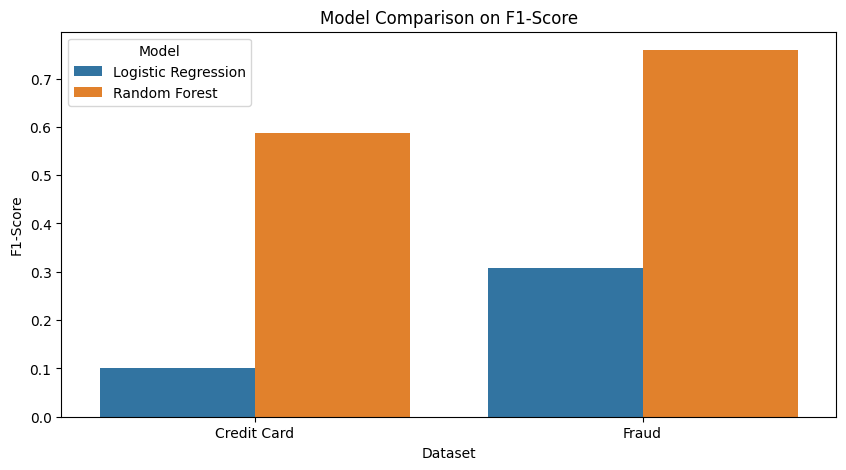

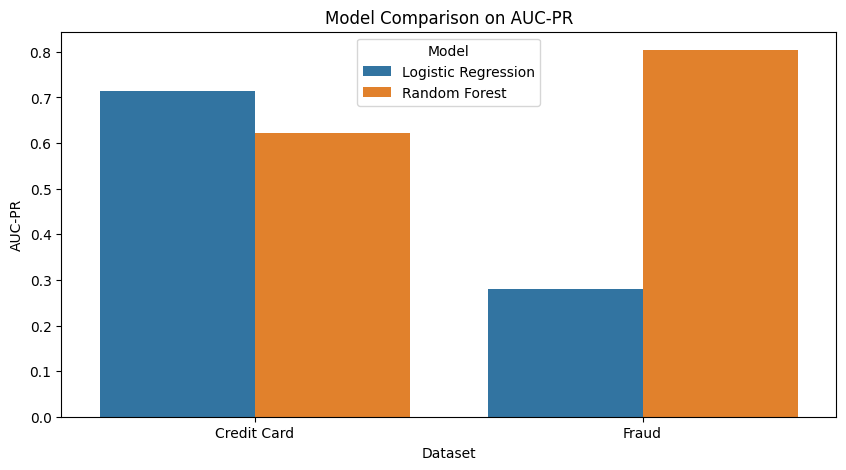

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.barplot(x="Dataset", y="F1-Score", hue="Model", data=df_comparison)
plt.title("Model Comparison on F1-Score")
plt.ylabel("F1-Score")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x="Dataset", y="AUC-PR", hue="Model", data=df_comparison)
plt.title("Model Comparison on AUC-PR")
plt.ylabel("AUC-PR")
plt.show()

# Model Comparison and Selection

## Overview

We compared multiple models on two datasets: **Credit Card Dataset** and **Fraud Dataset**.  
The evaluation metrics are:

- **AUC-PR** (Area Under Precision-Recall Curve): measures ranking ability, important for imbalanced datasets.  
- **F1-Score**: harmonic mean of precision and recall, measures thresholded performance on the positive class (fraud).  

---

## Metrics Summary

| Dataset       | Model                | AUC-PR  | F1-Score |
|---------------|--------------------|---------|----------|
| Credit Card   | Logistic Regression | 0.715   | 0.1002   |
| Credit Card   | Random Forest       | 0.6215  | 0.5875   |
| Fraud         | Logistic Regression | 0.2808  | 0.3072   |
| Fraud         | Random Forest       | 0.8039  | 0.7590   |

---

## Analysis

### Credit Card Dataset

- **Logistic Regression**  
  - *AUC-PR = 0.715*, *F1-score = 0.1002*  
  - Decent ranking ability but very poor actual detection of fraud.  

- **Random Forest**  
  - *AUC-PR = 0.6215*, *F1-score = 0.5875*  
  - Slightly lower ranking ability but much better at detecting fraud in practice.  

**Conclusion:** **Random Forest** is preferred for the Credit Card dataset due to higher F1-score.

---

### Fraud Dataset

- **Logistic Regression**  
  - *AUC-PR = 0.2808*, *F1-score = 0.3072*  
  - Performs poorly and cannot effectively detect fraud.  

- **Random Forest**  
  - *AUC-PR = 0.8039*, *F1-score = 0.7590*  
  - Clearly superior in both ranking and detection.  

**Conclusion:** **Random Forest** is the best choice for the Fraud dataset.

---

## Overall Recommendation

- **Random Forest consistently outperforms Logistic Regression** on both datasets in terms of **F1-score and AUC-PR**.  
- Logistic Regression is more interpretable but its low F1-scores make it unsuitable for practical fraud detection.  
- **Random Forest** should be selected for both datasets.

---

## Notes on Interpretability

Even though Random Forest is less interpretable than Logistic Regression:

- Feature importance can be extracted using:

```python
rf.feature_importances_
```

Cross-Validation Summary (Fraud Dataset)

Example 5-fold CV F1-scores:

array([0.9997573 , 0.99977939, 0.99964703, 0.99963602, 0.99968013])


Mean F1-score: 0.9997

Standard deviation: 0.00006

Interpretation:

Model is very stable across folds.
